# A Colour Illusion
This is designed to show you how your eye interpolates colour.

First, we'll import some useful libraries: skimage, matplotlib and numpy. We'll also inline matplotlib

In [1]:
import cv2 as cv2
import skimage as skimage
from skimage import io, data, color, filters
#from skimage.color import rgb2ycbcr
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

Now, we'll need a picture. Load it with OpenCV and get its dimensions. 

In [2]:
imageName = "tiger.bmp"
#imageName = "aphaniz_503.tiff"
img = skimage.io.imread(imageName)
#img = cv2.imread(imageName)
height, width = img.shape[:2]
print("The image is {} by {}".format(width, height))

The image is 1920 by 1080


And now display it using matplotlib.

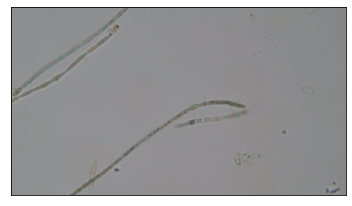

In [3]:
#plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
def showImage(image):
    plt.imshow(image, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
showImage(img)

In [5]:
from PIL import Image
im = Image.open(imageName)
pixels = list(im.getdata())
pixels = np.asarray(pixels, 'u1')
print (pixels.shape)
pixels.reshape

(2073600, 3)


<function ndarray.reshape>

And viewing the colour channels independently:

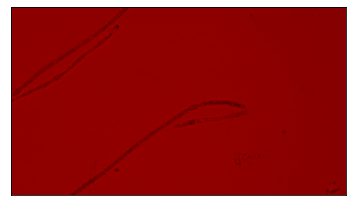

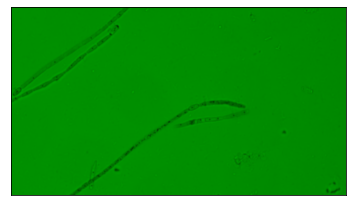

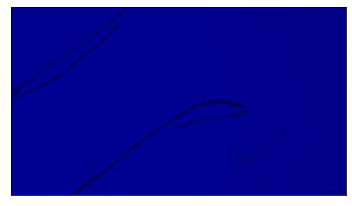

In [6]:
imgR = img.copy()
imgR[:,:,1] = 0
imgR[:,:,2] = 0
showImage(imgR)

imgG = img.copy()
imgG[:,:,0] = 0
imgG[:,:,2] = 0
showImage(imgG)

imgB = img.copy()
imgB[:,:,0] = 0
imgB[:,:,1] = 0
showImage(imgB)

And now, we'll convert to YUV colour space. Other colour spaces are available, but video coding uses a colour space called YUV420.  Here are the functions necessary for conversion (since opencv and skimage seem to completely fail to work in this colour space for me).

In [7]:
def thresholdAndRound(y):
    maxn = 255
    minn = 0
    y[y > maxn] = maxn
    y[y < minn] = minn
    y = np.around(y,0)
    return y

def convertToBytes(y):
    y = np.asarray(y, 'u1')
    return y

# planar YUV 4:4:4 to rgb
def planarYUV_2_planarRGB(data, width, height):
    #print("in planarYUV_2_planarRGB")
    maxn = 255
    minn = 0
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]    
    
    r = y + 1.403 * (v-delta)
    g = y - (0.714 * (v-delta)) - (0.344 * (u-delta))
    b = y + 1.773 * (u-delta)   
    
    r = thresholdAndRound(r)
    r = convertToBytes(r)
    g = thresholdAndRound(g)
    g = convertToBytes(g)
    b = thresholdAndRound(b)
    b = convertToBytes(b)
    
    rgb = np.concatenate((r,g,b), axis = 0)
    rgb = rgb.reshape((width*height*3), )
    return rgb

def quantiseUV(data, width, height):
    numLevels = 16
    q = 256/numLevels
    x = np.linspace(0, 10, 1000)
    
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]
    
    u = q * np.round(u/q)
    v = q * np.round(v/q)

    yuv = np.concatenate((y,u,v), axis = 0)
    return yuv

#Note that this function takes as input a planar RGB image
# It returns planar YUV4:4:4 (it's not common but it can be downsampled to 4:2:0)
def planarRGB_2_planarYUV(data, width, height):
    #print("in planarRGB_2_planarYUV")
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    r = np.array(picture[0])
    g = np.array(picture[1])
    b = np.array(picture[2])
    
    y = np.array(0.299*r + 0.587*g + 0.114*b)
    y = thresholdAndRound(y)
    u = ((b-y)*0.564) + delta
    v = ((r-y)*0.713) + delta
    
    y = thresholdAndRound(y)
    u = thresholdAndRound(u)
    v = thresholdAndRound(v)
    y = convertToBytes(y)
    u = convertToBytes(u)
    v = convertToBytes(v)
    
    yuv = np.concatenate((y,u,v), axis = 0)
    yuv = yuv.reshape((width*height*3), )
    
    return yuv

def RGB2YUV(img):
    width = img.shape[1]
    height = img.shape[0]
    img_ = np.transpose(img,(2,1,0))
    yuv = planarRGB_2_planarYUV(img_, width, height)
    yuv = yuv.reshape((3, width, height))
    #yuv = 255-yuv
    return yuv

def YUV2RGB(yuv):
    width = yuv.shape[1]
    height = yuv.shape[2]
    rgb = planarYUV_2_planarRGB(yuv, width, height)
    rgb = rgb.reshape((3, width, height))
    rgb = np.transpose(rgb, (2,1,0))
    return rgb


This is the Y channel

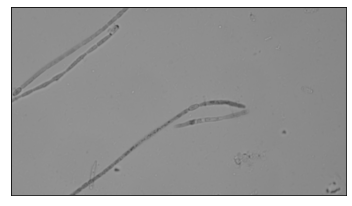

In [8]:
img_yuv = RGB2YUV(img)
imgY = img_yuv.copy()
#imgY[0, :, :] = 0
imgY[1, :, :] = 128
imgY[2, :, :] = 128

imgY_rgb = YUV2RGB(imgY)
showImage(imgY_rgb)

Then the U channel:

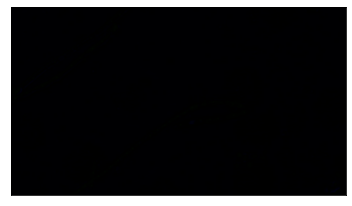

In [9]:
imgU = img_yuv.copy()
imgU[0, :, :] = 0
#imgU[1, :, :] = 128
imgU[2, :, :] = 128

imgU_rgb = YUV2RGB(imgU)
showImage(imgU_rgb)

Then the V channel:

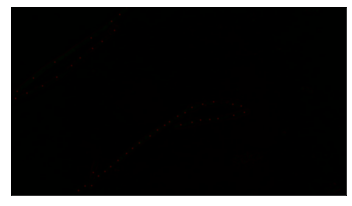

In [10]:
imgV = img_yuv.copy()
imgV[0, :, :] = 0
imgV[1, :, :] = 128
#imgV[2, :, :] = 128

imgV_rgb = YUV2RGB(imgV)
showImage(imgV_rgb)

As you can see, not much actual colour there

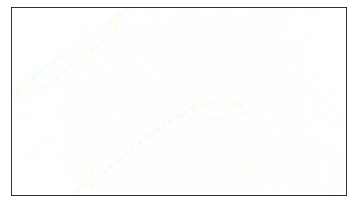

In [11]:
img_colour = img_yuv.copy()
img_colour[0, :, :] = 255

img_colour_rgb = YUV2RGB(img_colour)
showImage(img_colour_rgb)

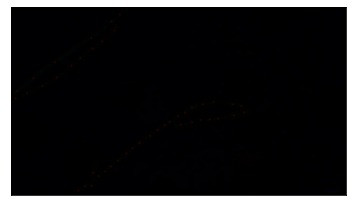

In [12]:
img_colour = img_yuv.copy()
img_colour[0, :, :] = 0

img_colour_rgb = YUV2RGB(img_colour)
showImage(img_colour_rgb)

And now we create a grid. First, it's just a vertical/horizontal grid which is double the dimensions of what we need. We're going to apply an affine transform and then crop out the centre part of the image so that we get a nice, even grid all over the image.

In [13]:
gridSpacing = 16
gridAngle = 60
grid = np.zeros((width*2, height*2))

for i in range(0, width*2):
    for j in range(0, height*2):
        if (i % gridSpacing) == 0:
            grid[i, j] = 1
        if (j % gridSpacing) == 0:
            grid[i, j] = 1
                
#print(grid)
print(grid.shape)

# Rotate the grid:
M = cv2.getRotationMatrix2D((height,width),gridAngle,1)
grid = cv2.warpAffine(grid,M,(height*2, width*2))
start_w = width//2
start_h = height//2
end_w = start_w + width
end_h = start_h + height
grid = grid[start_w:end_w, start_h:end_h]
grid[grid != 0] = 1

print(grid.shape)
        

(3840, 2160)
(1920, 1080)


And apply the grid to the image. Note that you have to set any "0" values to 128 in the colour channels because that gives greyscale.

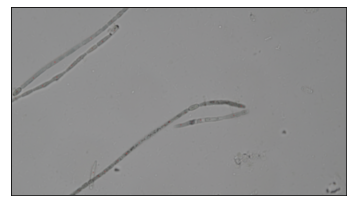

True

In [14]:
myY = imgY[0, :, :]
myU = np.multiply(grid, imgU[1, :, :])
myU[myU == 0] = 128
myV = np.multiply(grid, imgV[2, :, :])
myV[myV == 0] = 128

img_gridded = img_yuv.copy()
img_gridded[0, :, :] = myY
img_gridded[1, :, :] = myU
img_gridded[2, :, :] = myV

img_gridded_rgb = YUV2RGB(img_gridded)
showImage(img_gridded_rgb)
img_gridded_bgr = cv2.cvtColor(img_gridded_rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite("tiger.png", img_gridded_bgr)

Showing the three channels independently:

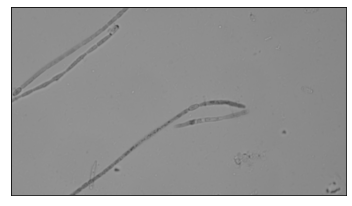

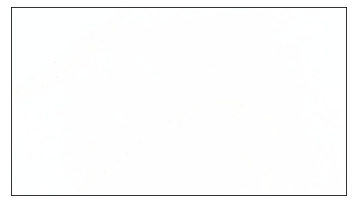

True

In [15]:
imgY = img_yuv.copy()
imgY[0, :, :] = myY
imgY[1, :, :] = 128
imgY[2, :, :] = 128
imgY_rgb = YUV2RGB(imgY)
showImage(imgY_rgb)
imgY_bgr = cv2.cvtColor(imgY_rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite("ytiger.png", imgY_bgr)

imgUV = img_yuv.copy()
imgUV[0, :, :] = 255
imgUV[1, :, :] = myU
imgUV[2, :, :] = myV
imgUV_rgb = YUV2RGB(imgUV)
showImage(imgUV_rgb)
imgUV_bgr = cv2.cvtColor(imgUV_rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite("uvtiger.png", imgUV_bgr)

And now, to show just how little colour is in that image, this is the complete image with the grid applied:

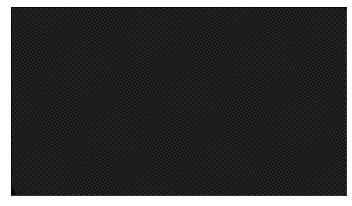

In [16]:
myY = imgY[0, :, :]
myY = np.multiply(grid, imgY[1, :, :])
myU = np.multiply(grid, imgU[1, :, :])
myU[myU == 0] = 128
myV = np.multiply(grid, imgV[2, :, :])
myV[myV == 0] = 128

img_gridded = img_yuv.copy()
img_gridded[0, :, :] = myY
img_gridded[1, :, :] = myU
img_gridded[2, :, :] = myV

img_gridded_rgb = YUV2RGB(img_gridded)
showImage(img_gridded_rgb)